# Graph implementation of the courses

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords

import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df1=pd.read_csv('data/Coursera.csv')
df2=pd.read_csv('data/Coursera_courses.csv')

In [4]:
df1.head()

,Course Name,University,Difficulty Level,Course Rating,Course URL,Course Description,Skills
0,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,https://www.coursera.org/learn/write-a-feature...,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,Business Strategy: Business Model Canvas Analy...,Coursera Project Network,Beginner,4.8,https://www.coursera.org/learn/canvas-analysis...,"By the end of this guided project, you will be...",Finance business plan persona (user experien...
2,Silicon Thin Film Solar Cells,�cole Polytechnique,Advanced,4.1,https://www.coursera.org/learn/silicon-thin-fi...,This course consists of a general presentation...,chemistry physics Solar Energy film lambda...
3,Finance for Managers,IESE Business School,Intermediate,4.8,https://www.coursera.org/learn/operational-fin...,"When it comes to numbers, there is always more...",accounts receivable dupont analysis analysis...
4,Retrieve Data using Single-Table SQL Queries,Coursera Project Network,Beginner,4.6,https://www.coursera.org/learn/single-table-sq...,In this course you�ll learn how to effectively...,Data Analysis select (sql) database manageme...


In [5]:
df2.head()

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training


## Preprocessing

### Merge datasets to be sure to work on the courses that actually have a description

In [6]:
#Delete useless columns and rename columns to be the same
# df1 = df1[['Course Name','University','Difficulty Level','Course Rating','Course Description','Skills']]
df1.columns = ['name','institution','level','rating','course_url','desc','skills']

In [7]:
#Combine the dataframes into one for the common courses based on the course_url
df_init = pd.merge(df1[['name','institution','level','rating','course_url','desc','skills']], df2[['course_url','course_id']], on='course_url')
#only keep useful columns
df_init = df_init[['course_id','name','institution','level','rating','desc','skills']]
print(df_init.shape)
df_init.head()

(540, 7)


,course_id,name,institution,level,rating,desc,skills
0,write-a-feature-length-screenplay-for-film-or-...,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,programming-languages,"Programming Languages, Part A",University of Washington,Intermediate,4.9,This course is an introduction to the basic co...,inference ml (programming language) higher-o...
2,introduction-cybersecurity-cyber-attacks,Introduction to Cybersecurity Tools & Cyber At...,IBM,Beginner,4.3,This course gives you the background needed to...,cyber-security regulation cyber security stan...
3,introduction-cybersecurity-cyber-attacks,Introduction to Cybersecurity Tools & Cyber At...,IBM,Beginner,4.3,This course gives you the background needed to...,cyber-security regulation cyber security stan...
4,epigenetics,Epigenetic Control of Gene Expression,The University of Melbourne,Beginner,4.8,While the human genome sequence has transforme...,Cancer reproductive technology Dna Methylati...


In [8]:
print(df_init[df_init.duplicated(subset="course_id", keep=False)])

                                             course_id   
2             introduction-cybersecurity-cyber-attacks  \
3             introduction-cybersecurity-cyber-attacks   
13   ibm-penetration-testing-incident-response-fore...   
14   ibm-penetration-testing-incident-response-fore...   
26                                     producing-music   
..                                                 ...   
506                                   gcp-fundamentals   
507                                   gcp-fundamentals   
508                                   gcp-fundamentals   
535                      applied-data-science-capstone   
536                      applied-data-science-capstone   

                                                  name   
2    Introduction to Cybersecurity Tools & Cyber At...  \
3    Introduction to Cybersecurity Tools & Cyber At...   
13   Penetration Testing, Incident Response and For...   
14   Penetration Testing, Incident Response and For...   
26           

### Merge datasets to be sure to work on the courses that actually have a user review

In [9]:
df_users =pd.read_csv('data/Coursera_reviews.csv')

In [10]:
common_values = set(df_init['course_id']).intersection(df_users['course_id'])
count_common_values = len(common_values)

print("Number of common unique values:", count_common_values)

Number of common unique values: 469


In [11]:
column_to_compare = df_users['course_id']

# Filter df_init to keep rows with common courses (courses with user reviews)
df_init = df_init[df_init['course_id'].isin(column_to_compare.unique())]

print(df_init.shape)
df_init.head()

(527, 7)


,course_id,name,institution,level,rating,desc,skills
0,write-a-feature-length-screenplay-for-film-or-...,Write A Feature Length Screenplay For Film Or ...,Michigan State University,Beginner,4.8,Write a Full Length Feature Film Script In th...,Drama Comedy peering screenwriting film D...
1,programming-languages,"Programming Languages, Part A",University of Washington,Intermediate,4.9,This course is an introduction to the basic co...,inference ml (programming language) higher-o...
2,introduction-cybersecurity-cyber-attacks,Introduction to Cybersecurity Tools & Cyber At...,IBM,Beginner,4.3,This course gives you the background needed to...,cyber-security regulation cyber security stan...
3,introduction-cybersecurity-cyber-attacks,Introduction to Cybersecurity Tools & Cyber At...,IBM,Beginner,4.3,This course gives you the background needed to...,cyber-security regulation cyber security stan...
4,epigenetics,Epigenetic Control of Gene Expression,The University of Melbourne,Beginner,4.8,While the human genome sequence has transforme...,Cancer reproductive technology Dna Methylati...


### Preprocess the courses descriptions

In [12]:
df = df_init.copy()

In [13]:
# change level from string to numerical
level_mapping = {
    'Beginner': 1,
    'Intermediate': 2,
    'Conversant': 3,
    'Advanced': 4
}

df['level'] = df['level'].map(level_mapping)

In [14]:
def remove_punctuation(txt):
  txt_nopunt= "".join([c for c in txt if c not in string.punctuation])
  return txt_nopunt

nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#reduce each course to tag
df['desc'] = df['desc'].str.replace('http\S+|www.\S+', '', case=False)

df['desc']=df['desc'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['name']=df['name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['skills']=df['skills'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df['name']=df['name'].replace(","," ",regex=True)
df['desc']=df['desc'].replace(","," ",regex=True)
df['skills']=df['skills'].replace(","," ",regex=True)
df['skills']=df['skills'].replace("-"," ",regex=True)

df['name']=df['name'].apply(lambda x: remove_punctuation(x))
df['desc']=df['desc'].apply(lambda x: remove_punctuation(x))
df['skills']=df['skills'].apply(lambda x: remove_punctuation(x))

df['desc']=df['desc'].replace("�","'",regex=True)
df['name']=df['name'].replace("�","'",regex=True)

df['tags']=df['name']+' '+ df['desc']+' '+df['skills']

df_courses = df.copy()

Now add, for each course, include the main topics part of the tags (= name + level + desc + skills)

In [16]:
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS

# Define your custom stop words
custom_stopwords = ["course", "this", "the","you","learn","learning","also","use","able",
                    "process","basic","work","understand","new","complete","including","access",
                    "module","students","help","skills","understanding","different","world","key"]  # Add stop words to this list

# Combine custom stop words with default gensim stop words
all_stopwords = STOPWORDS.union(set(custom_stopwords))

# Preprocessing the text data and filtering stop words
documents = df_courses['tags'].tolist()
processed_docs = [doc.lower().split() for doc in documents]

In [17]:
# Combine specific words as a single token
for doc in processed_docs:
    for i in range(len(doc) - 1):
        if doc[i] == "data" and doc[i + 1] == "science":
            doc[i] = "data_science"
            doc[i + 1] = ""  
        if doc[i] == "machine" and doc[i + 1] == "learning":
            doc[i] = "machine_learning"
            doc[i + 1] = ""  
        

In [18]:
# Remove empty strings from processed documents
processed_docs = [[word for word in doc.lower().split() if word not in all_stopwords] for doc in documents]

# Creating the dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Running LDA
num_topics = 10  # Set the desired number of topics
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Get topic labels
topic_labels = lda_model.show_topics(num_topics=num_topics, formatted=False)

# Extracting main topics for each course
topics = []
for doc_bow in corpus:
    doc_topics = lda_model.get_document_topics(doc_bow)
    main_topic, weight = max(doc_topics, key=lambda x: x[1])
    topic_label = next((label for label in topic_labels if label[0] == main_topic), None)
    topic_name = f"{topic_label[1]} (Weight: {weight:.2f})"
    topics.append(topic_name)

# Adding the topics to the DataFrame
df_courses['main_topic'] = topics

In [19]:
print(df_courses['main_topic'])

0      [('law', 0.024755318), ('international', 0.013...
1      [('programming', 0.010745021), ('drug', 0.0101...
2      [('python', 0.010552682), ('programming', 0.00...
3      [('python', 0.010552682), ('programming', 0.00...
4      [('python', 0.010552682), ('programming', 0.00...
                             ...                        
535    [('data', 0.0578746), ('analysis', 0.018063713...
536    [('data', 0.0578746), ('analysis', 0.018063713...
537    [('python', 0.010552682), ('programming', 0.00...
538    [('python', 0.010552682), ('programming', 0.00...
539    [('data', 0.0578746), ('analysis', 0.018063713...
Name: main_topic, Length: 527, dtype: object


In [20]:
print(df_courses.columns)

Index(['course_id', 'name', 'institution', 'level', 'rating', 'desc', 'skills',
       'tags', 'main_topic'],
      dtype='object')


## Graph Network based on courses similarities

Graph based on several similarities : the similarities of the courses insitution, rating, main topic, level and skills

In [21]:
def compute_similarity_text(col):
    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    
    # Apply TF-IDF vectorization on text metric
    tfidf_matrix = vectorizer.fit_transform(col)
    
    return cosine_similarity(tfidf_matrix)
    

In [22]:
# Calculate similarity scores for each similarity metric
similarity_institution = compute_similarity_text(df_courses['institution'])  # Compute similarity scores based on institution
similarity_rating = cosine_similarity(df_courses['rating'].values.reshape(-1, 1)) # Compute similarity scores based on rating
similarity_main_topic = compute_similarity_text(df_courses['main_topic'])  # Compute similarity scores based on main topic
similarity_level = cosine_similarity(df_courses['level'].values.reshape(-1, 1))  # Compute similarity scores based on level
similarity_skills = compute_similarity_text(df_courses['skills'])  # Compute similarity scores based on skills

#TODO Normalize similarity scores (if necessary)

In [23]:
# Create an empty graph
graph = nx.Graph()

# Add courses as nodes to the graph
for i,row in df_courses.iterrows():
    graph.add_node(i, id=row['course_id'], name=row['name'],institution = row['institution'],level = df_courses['level'],
                   rating = df_courses['rating'], desc = df_courses['desc'], skills = df_courses['skills'], 
                   tags = df_courses['tags'],main_topic = df_courses['main_topic'])
    
threshold_institution = 0.5
threshold_rating = 0.2
threshold_main_topic = 0.7
threshold_level = 0.2
threshold_skills = 0.3
# Set the minimum number of threshold crossings required
min_threshold_crossings = 3

similarity_thresholds = [threshold_institution,
                                    threshold_rating,
                                    threshold_main_topic,
                                    threshold_level,
                                    threshold_skills]

# Add edges based on similarity scores and threshold crossings
num_courses = len(df['name'])
for i in range(num_courses):
    for j in range(i + 1, num_courses):
        # Check if the nodes already exist in the graph
        if i in graph.nodes() and j in graph.nodes():
            similarity_scores = [similarity_institution[i][j],
                                similarity_rating[i][j],
                                similarity_main_topic[i][j],
                                similarity_level[i][j],
                                similarity_skills[i][j]]

            # Count the number of threshold crossings
            threshold_crossings = sum(score > threshold for score, threshold in zip(similarity_scores, similarity_thresholds))
            weights = np.array([0.1, 0.4, 0.2, 0.15, 0.15])  # assume rating similarity is twice as important
            overall_similarity = np.average(similarity_scores, weights=weights)
            if threshold_crossings >= min_threshold_crossings:
                graph.add_edge(i, j, weight=overall_similarity)  # Add edge with maximum similarity score

In [24]:
print(graph)

def get_sparsity(G):
    num_nodes = len(G.nodes())
    num_edges = len(G.edges())
    return 1.0 - (2.0 * num_edges) / (num_nodes * (num_nodes - 1))

print("Sparsity:", get_sparsity(graph))

Graph with 527 nodes and 19056 edges
Sparsity: 0.8625118144890729


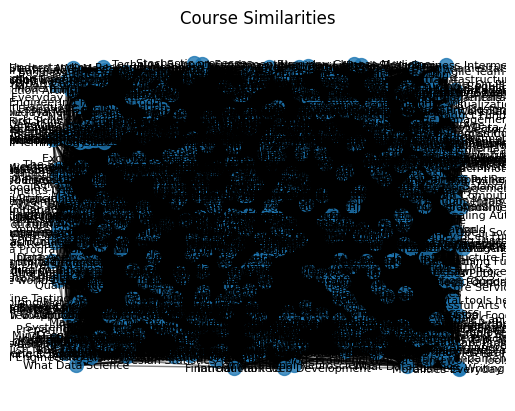

In [25]:
# Set the layout for visualization
layout = nx.random_layout(graph)

# Draw the nodes and edges
nx.draw_networkx_nodes(graph, layout, node_size=100, alpha=0.8)
nx.draw_networkx_edges(graph, layout, alpha=0.5)

# Add labels to the nodes
labels = nx.get_node_attributes(graph, 'name')
nx.draw_networkx_labels(graph, layout, labels, font_size=8)

# Set the plot title and show the graph
plt.title('Course Similarities')
plt.axis('off')
plt.show()

In [26]:
import pickle

file_path = "graphs/course_graph.pickle"

with open(file_path, "wb") as file:
    pickle.dump(graph, file)

In [27]:
with open(file_path, "rb") as file:
    graph = pickle.load(file)
    
print(graph)

Graph with 527 nodes and 19056 edges
